# This notebook will be used to retrieve all handposes from all dataset videos. 

In [88]:
import mediapipe as mp
import cv2
import numpy as np
import uuid
import os
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import scipy.interpolate
from scipy.interpolate import UnivariateSpline

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh

## Open a video

In [3]:
cap = cv2.VideoCapture("dataset/videos/00414.mp4")
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        cv2.imshow('frame',frame)
    else:
        break
    if cv2.waitKey(20) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## Detect handpose one a single video

In [4]:
hand_position = []
cap = cv2.VideoCapture("dataset/videos/00414.mp4")
with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5) as hands: 
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.7) as face_mesh:
        while cap.isOpened():
            ret, frame = cap.read()

            if ret:

                # Flip on horizontal
                image = cv2.flip(frame, 1)

                # Set flag
                image.flags.writeable = False

                # Detections
                hand_results = hands.process(image)
                face_results = face_mesh.process(image)
                
                if hand_results.multi_handedness:
                    print(hand_results.multi_handedness)

                # Set flag to true
                image.flags.writeable = True

                # Rendering results
                
                #Detect hands position
                if hand_results.multi_hand_landmarks:
                    # At least one hand has been detected
                    temp_hand_position = []
                    for num, hand in enumerate(hand_results.multi_hand_landmarks):
                        mp_drawing.draw_landmarks(image, hand, mp_hands.HAND_CONNECTIONS, 
                                                mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                                mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2, circle_radius=2),
                                                 )
                    hand_position.append(hand_results.multi_hand_landmarks)

                    #Detect face position
                    if face_results.multi_face_landmarks:
                        #Face has been detected
                        temp_face_position = []
                        for face_landmarks in face_results.multi_face_landmarks:
                            mp_drawing.draw_landmarks(
                              image,
                              landmark_list=face_landmarks,
                              connections=mp_face_mesh.FACEMESH_TESSELATION,
                              landmark_drawing_spec=None,
                              connection_drawing_spec=mp_drawing_styles
                              .get_default_face_mesh_tesselation_style())

                            mp_drawing.draw_landmarks(
                              image,
                              landmark_list=face_landmarks,
                              connections=mp_face_mesh.FACEMESH_CONTOURS,
                              landmark_drawing_spec=None,
                              connection_drawing_spec=mp_drawing_styles
                              .get_default_face_mesh_contours_style())
                            mp_drawing.draw_landmarks(
                              image,
                              landmark_list=face_landmarks,
                              connections=mp_face_mesh.FACEMESH_IRISES,
                              landmark_drawing_spec=None,
                              connection_drawing_spec=mp_drawing_styles
                              .get_default_face_mesh_iris_connections_style())
                        temp_face_position.append(face_results.multi_face_landmarks[0])

                # Showing our image    
                cv2.imshow('Hand and Face Tracking', image)
            else :
                break

            if cv2.waitKey(50) & 0xFF == ord('q'):
                break

cap.release()
cv2.destroyAllWindows()

[classification {
  index: 1
  score: 0.986327052116394
  label: "Right"
}
]
[classification {
  index: 1
  score: 0.9990025758743286
  label: "Right"
}
]
[classification {
  index: 0
  score: 0.9935113787651062
  label: "Left"
}
, classification {
  index: 1
  score: 0.9980832934379578
  label: "Right"
}
]
[classification {
  index: 0
  score: 0.9849422574043274
  label: "Left"
}
, classification {
  index: 1
  score: 0.9960534572601318
  label: "Right"
}
]
[classification {
  index: 0
  score: 0.9946630597114563
  label: "Left"
}
, classification {
  index: 1
  score: 0.9966831803321838
  label: "Right"
}
]
[classification {
  index: 0
  score: 0.9946225881576538
  label: "Left"
}
, classification {
  index: 1
  score: 0.9937425255775452
  label: "Right"
}
]
[classification {
  index: 0
  score: 0.9969989061355591
  label: "Left"
}
, classification {
  index: 1
  score: 0.9919272065162659
  label: "Right"
}
]
[classification {
  index: 0
  score: 0.9965115189552307
  label: "Left"
}


### Get the first coordinate from the first recognized hand placement. Each tracked hand is composed of 21 reference points characterized by 3 coordinates: x, y (2D coordinates) and z (depth).

In [5]:
hand_position[2][0].landmark[0]

x: 0.36996397376060486
y: 0.9045831561088562
z: -1.5093831962076365e-08

In [6]:
hand_position[2][1].landmark[0]

x: 0.6783121824264526
y: 0.875123143196106
z: 5.7871204717230285e-08

In [8]:
def get_coordinate_from_landmark(landmark):
    ''' Extract 3D coordinates of a landmark'''
    return np.array([[landmark.x, landmark.y, landmark.z]])

def get_positions_from_track(tracks, handness=None):
    
    ''' Return a vector of length 42 linked to the 21 landmarks of each hand. 
        If a hand has not been recognized, landmarks 2D positions values are -1 by default
    '''
    # Notation : first 21 landmarks linked to left hand and the last 21 landmarks linked to right hand
    if handness:
        if len(handness) == 1:
            #A single hand has been tracked
            label = handness[0].classification[0].label
            simulated_hands = np.zeros(shape=(21, 3))
            all_positions = np.concatenate([get_coordinate_from_landmark(landmark) for landmark in tracks[0].landmark], axis = 0)
            if label == "Left":
                all_positions = np.concatenate((all_positions, simulated_hands), axis = 0)
            else:
                all_positions = np.concatenate((simulated_hands, all_positions), axis = 0)
        else:
            # Two hands has been detected
            label = handness[0].classification[0].label
            
            first_hand = np.concatenate([get_coordinate_from_landmark(landmark) for landmark in tracks[0].landmark], axis = 0)
            second_hand = np.concatenate([get_coordinate_from_landmark(landmark) for landmark in tracks[1].landmark], axis = 0)
            if label == "Left":
                all_positions = np.concatenate((first_hand, second_hand), axis = 0)
            else:
                all_positions = np.concatenate((second_hand, first_hand), axis = 0)

    else:
        all_positions = np.concatenate([get_coordinate_from_landmark(landmark) for landmark in tracks[0].landmark], axis = 0)
    return all_positions

def get_all_tracked_hand(finename_video):
    
    hand_position = []
    face_position = []
    cap = cv2.VideoCapture(finename_video)
    with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5) as hands: 
        with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.7) as face_mesh:
            while cap.isOpened():
                ret, frame = cap.read()

                if ret:

                    # Flip on horizontal
                    image = cv2.flip(frame, 1)

                    # Set flag
                    image.flags.writeable = False

                    # Detections
                    hand_results = hands.process(image)
                    face_results = face_mesh.process(image)

                    if hand_results.multi_hand_landmarks:
                        # Hands has been recognized
                        handness = hand_results.multi_handedness
                                          
                        hand_position.append(get_positions_from_track(hand_results.multi_hand_landmarks, handness))
                        
                        if face_results.multi_face_landmarks:
                            #Face has been recognized
                            face_position.append(get_positions_from_track(face_results.multi_face_landmarks))
                        else:
                            face_position.append(-np.ones(shape = (478,3)))
                else :
                    break

    cap.release()
    
    hand_position = np.array(hand_position)
    face_position = np.array(face_position)
    if len(hand_position) != 0:
        all_position = np.concatenate((hand_position, face_position), axis = 1)
    else :
        all_position = []
    return all_position

In [9]:
track = get_all_tracked_hand("dataset/videos/00414.mp4")

In [10]:
track.shape

(71, 520, 3)

In [11]:
path_to_videos = os.getcwd()+'/dataset/videos'

### Detecting all videos

In [12]:
hands_tracked = {}
for count, filename in tqdm(enumerate(os.listdir(path_to_videos))):
    track = get_all_tracked_hand(path_to_videos+'/'+filename)
    if len(track) > 0 :
        hands_tracked[filename] = track
    if count % 1000 == 0:
        pickle.dump(hands_tracked, open('all_record.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

11980it [36:23:27, 10.94s/it]  


In [13]:
pickle.dump(hands_tracked, open('all_record.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
len(hands_tracked)

6178

Only 6178 videos contains at least one hand detected by mediapipe.

## Analysing detections

In [17]:
len_sequence_video_detected = np.array([len(seq) for seq in hands_tracked.values()])

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

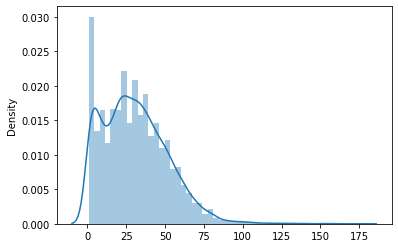

In [21]:
sns.distplot(len_sequence_video_detected)

In [24]:
len(len_sequence_video_detected[len_sequence_video_detected < 5])/len(len_sequence_video_detected)

0.10440271932664293

10% of the dataset contains sequence less than 5 images to depict a sign. 

In [36]:
keys_dict = list(hands_tracked.keys())

In [40]:
cleaned_hands_tracked = { keys_dict[id_key] : hands_tracked[keys_dict[id_key]] for id_key in np.where(len_sequence_video_detected >= 5)[0]}

In [41]:
len(cleaned_hands_tracked)

5533

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

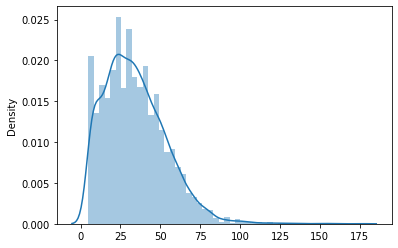

In [42]:
len_sequence_video_detected = np.array([len(seq) for seq in cleaned_hands_tracked.values()])
sns.distplot(len_sequence_video_detected)

In [356]:
#pickle.dump(cleaned_hands_tracked, open('record_cleaned.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
record = pickle.load(open("record_cleaned.pkl", "rb"))

In [357]:
min_ = [1, 1, 1]
max_ = [-1, -1, -1]
for elem in record.values():
    temp_min, temp_max = np.min(elem, axis = (0,1)), np.max(elem, axis = (0,1))
    for dim in range(3):
        if temp_min[dim] < min_[dim] :
            min_[dim] = temp_min[dim]
        if temp_max[dim] > max_[dim] :
            max_[dim] = temp_max[dim]

In [358]:
print(min_, max_)

[-0.06325573474168777, -0.12253961712121964, -0.2711982727050781] [1.0569168329238892, 1.1226613521575928, 0.1358286738395691]


In [359]:
min_ = np.array(min_)
max_ = np.array(max_)

In [360]:
for key in record.keys():
    dim1, dim2 = record[key].shape[:-1]
    record[key] = (record[key].reshape(dim1*dim2, 3) - min_)/(max_ - min_)
    record[key] = record[key].reshape(dim1, dim2, 3)

In [361]:
pickle.dump((min_, max_), open('Min_max.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

## Construct all tracking with the same number of sequence

Has it will be feed to a deep neural network, we need to have a fixed number of sequence for each record. To do that, a smooth interpolation will be made by using spline RBF interpolation.

In [362]:
number_of_sequences = 100

In [363]:
all_sequences = list(record.values())

In [364]:
all_sequences[0][0].shape

(520, 3)

In [365]:
all_sequences[0][0][21:42, 0]

array([0.63663753, 0.61766627, 0.59360556, 0.57123731, 0.55608442,
       0.57360756, 0.53485428, 0.51063888, 0.4910689 , 0.57507291,
       0.53363002, 0.50502999, 0.4818323 , 0.57978234, 0.54171776,
       0.51667825, 0.49801867, 0.58618944, 0.55573786, 0.53646245,
       0.52041435])

In [366]:
len(all_sequences[0])

22

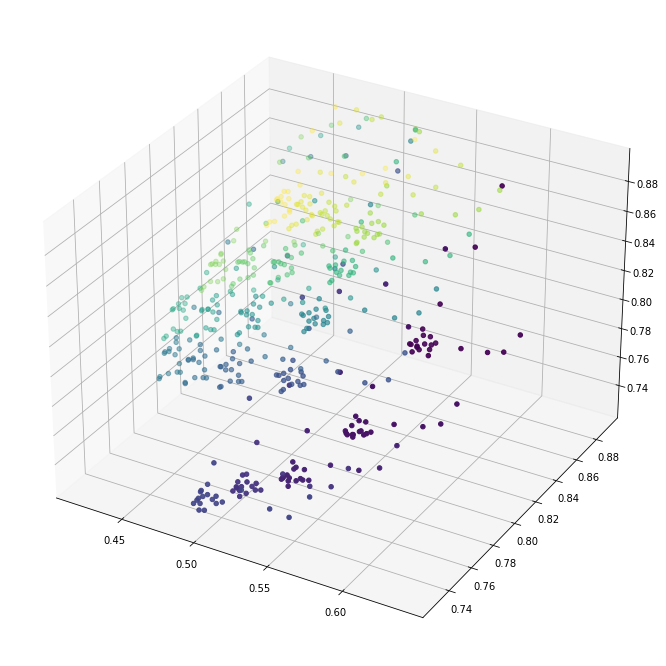

In [367]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for nb_seq in range(len(all_sequences[0])):
    ax.scatter(all_sequences[0][nb_seq, 21:42, 0], all_sequences[0][nb_seq,21:42, 1], all_sequences[0][nb_seq, 21:42, 1], c = list(range(21)))
plt.show()

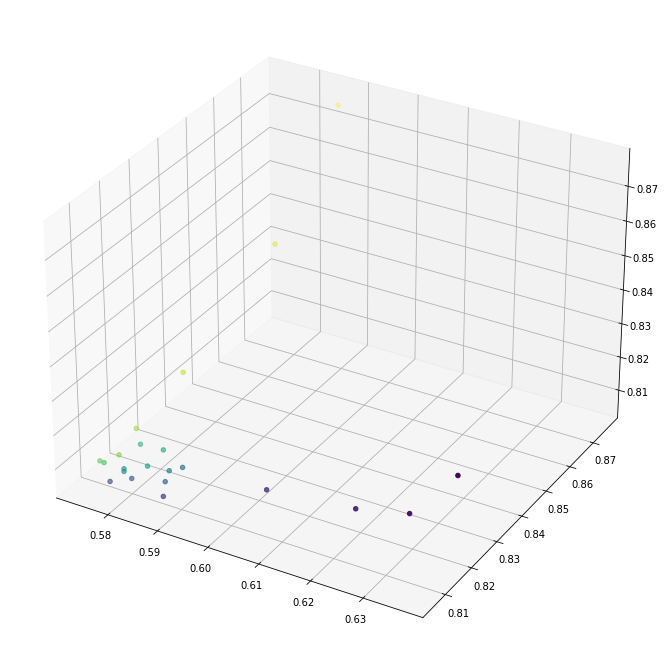

In [368]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(all_sequences[0][:, 21, 0], all_sequences[0][:,21, 1], all_sequences[0][:, 21, 1], c = list(range(len(all_sequences[0]))))
plt.show()

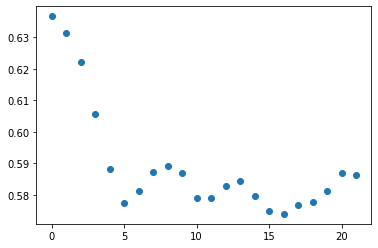

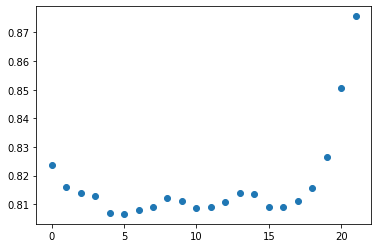

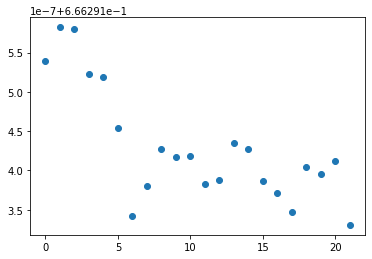

In [369]:
plt.scatter(list(range(len(all_sequences[0]))), all_sequences[0][:, 21, 0])
plt.show()
plt.scatter(list(range(len(all_sequences[0]))), all_sequences[0][:, 21, 1])
plt.show()
plt.scatter(list(range(len(all_sequences[0]))), all_sequences[0][:, 21, 2])
plt.show()

In [411]:
x = list(range(len(all_sequences[0])))
new_x = np.linspace(0, x[-1], number_of_sequences)

spl1 = UnivariateSpline(x, all_sequences[0][:, 21, 0], s=5e-6)
spl2 = UnivariateSpline(x, all_sequences[0][:, 21, 1], s=5e-6)
spl3 = UnivariateSpline(x, all_sequences[0][:, 21, 2], s=5e-6)

new_seq1 = spl1(new_x)
new_seq2 = spl2(new_x)
new_seq3 = spl3(new_x)

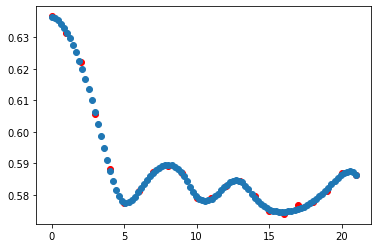

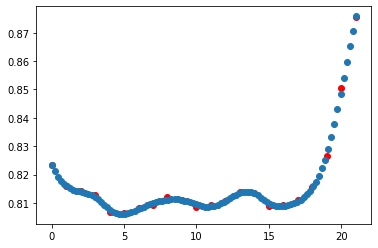

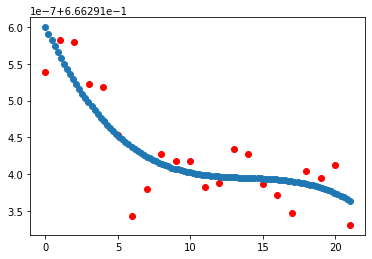

In [412]:
plt.scatter(list(range(len(all_sequences[0]))), all_sequences[0][:, 21, 0], c = 'red')
plt.scatter(new_x,new_seq1)
plt.show()

plt.scatter(list(range(len(all_sequences[0]))), all_sequences[0][:, 21, 1], c = 'red')
plt.scatter(new_x,new_seq2)
plt.show()

plt.scatter(list(range(len(all_sequences[0]))), all_sequences[0][:, 21, 2], c = 'red')
plt.scatter(new_x,new_seq3)
plt.show()

In [413]:
def spline_interpolation_landmark(landmark, number_of_sequences):
    '''
        Spline interpolation for a single landmark with shape(nb_seq, 3)
    '''
    
    x = list(range(len(landmark)))
    new_x = np.linspace(0, x[-1], number_of_sequences)

    spl1 = UnivariateSpline(x, landmark[:, 0], s=5e-6)
    spl2 = UnivariateSpline(x, landmark[:, 1], s=5e-6)
    spl3 = UnivariateSpline(x, landmark[:, 2], s=5e-6)

    new_seq1 = spl1(new_x)
    new_seq2 = spl2(new_x)
    new_seq3 = spl3(new_x)
    
    interpolated_landmark = np.vstack((new_seq1, new_seq2, new_seq3)).T
    return interpolated_landmark

In [414]:
test = spline_interpolation_landmark(all_sequences[0][:,21,:], number_of_sequences)

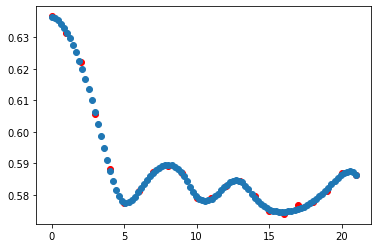

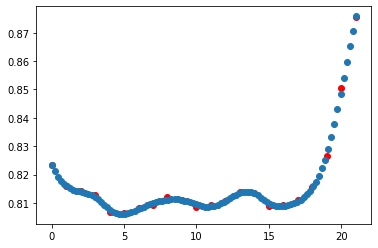

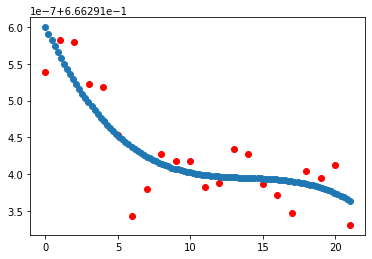

In [415]:
plt.scatter(list(range(len(all_sequences[0]))), all_sequences[0][:, 21, 0], c = 'red')
plt.scatter(new_x, test[:,0])
plt.show()

plt.scatter(list(range(len(all_sequences[0]))), all_sequences[0][:, 21, 1], c = 'red')
plt.scatter(new_x, test[:,1])
plt.show()

plt.scatter(list(range(len(all_sequences[0]))), all_sequences[0][:, 21, 2], c = 'red')
plt.scatter(new_x, test[:,2])
plt.show()

In [416]:
def spline_interpolation_landmarks(landmarks, number_of_sequences):
    '''
        Spline interpolation for all landmarks with shape(nb_seq, nb_landmarks, 3)
    '''
    
    interpolation = []
    for landmark in landmarks:
        interpolation.append(spline_interpolation_landmark(landmark, number_of_sequences))
    interpolation = np.array(interpolation)
    
    return interpolation

In [417]:
test = spline_interpolation_landmarks(all_sequences[0].reshape(520, 22, 3), number_of_sequences)

In [418]:
test.shape

(520, 100, 3)

In [421]:
def all_videos_interpolation(all_record, number_of_sequences):
    
    """
        Spline interpolation for all videos saved into a dictionary format
    """
    interpolation = {}
    for key_record, values_records in tqdm(all_record.items()):
        nb_seq, nb_landmarks = values_records.shape[:-1]
        interpolation[key_record] = spline_interpolation_landmarks(values_records.reshape(nb_landmarks, nb_seq, 3), number_of_sequences)

    return interpolation

In [422]:
final_cleaned_record = all_videos_interpolation(record, number_of_sequences)

100%|██████████████████████████████████████████████████████████████████████████████| 5533/5533 [30:46<00:00,  3.00it/s]


In [423]:
pickle.dump(final_cleaned_record, open('final_record_cleaned.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
#record = pickle.load(open("final_record_cleaned.pkl", "rb"))